# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [54]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/rhAirpuff'
file_container_obj = FileContainer(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231004_Gandalf_UnityVR.bhv2
  MonkeyLogic Date: 231004
  MonkeyLogic Monkey: gandalf
Select directory containing White Matter video files (i.e. 230927_Aragorn)
Video files directory selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231004_Gandalf
  White Matter Video Date: 231004
  White Matter Video Monkey: gandalf
Select directory containing SpikeGLX files
SpikeGLX files directory selected: /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/UnityVR/gandalf_20231004_g1
  SpikeGLX Date: 231004
  SpikeGLX Monkey: gandalf



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [64]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 413
Parsing session data...


  0%|          | 0/413 [00:00<?, ?it/s]

  Complete.
    Correct trials: 259
    Errored trials: 154
    Session Length:  01:55:22
Creating Session Objects...
Lick threshold: 2.53 mV
Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [65]:
session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
session_obj.df['cam_sync'] = session_obj.df['lick'].copy()
session_obj.df['lick'] = session_obj.df['cam_sync_2'].copy()
del session_obj.df['cam_sync_2']

In [66]:
from config.add_fields import add_fields
session_obj.df, session_obj = add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), session_obj.df, 'gandalf', 'UnityVR',
            error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX
Once you have `session_obj` with a `df` attribute referencing a `pd.DataFrame`, it will check for required fields `photodiode`, `cam_sync`, and `cam_save`. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
Sample Rate:  2000.0
 Channel [0]: cam_sync
  Max Val: 3340.149
  Min Val: -4.883
 Channel [1]: cam_save
  Max Val: 3344.421
  Min Val: -6.256
 Channel [2]: lick
  Max Val: 4999.847
  Min Val: -15.106
 Channel [3]: photodiode
  Max Val: 2314.911
  Min Val: 424.194
 Channel [4]: empty
  Max Val: 0.0
  Min Val: 0.0


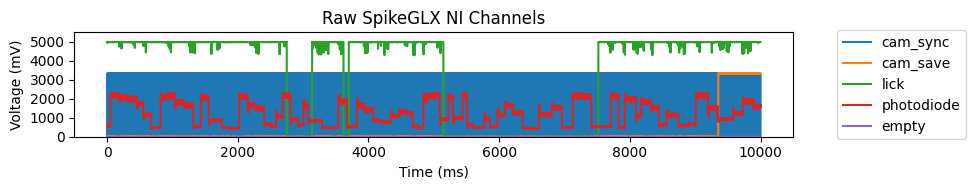

In [86]:
%load_ext autoreload
%autoreload 2
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
  4: 'empty'
}
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, 0, 10)


Pickled spikeglx_obj not found for: gandalf_231004
Generating new spikeglx_obj...
  Looking for SpikeGLX binary and meta file in:
  /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/UnityVR
Looking for binary file in /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/UnityVR
Found folder: gandalf_20231004_g1
  Found binary file: gandalf_20231004_g1_t0.nidq.bin
  Found metadata file: gandalf_20231004_g1_t0.nidq.meta
File Name: C:/Users/Penfield/Desktop/Rob/SpikeGLX/gandalf_20231004_g1/gandalf_20231004_g1_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-10-04T10:48:20
  File Length: 6992.678
nChan: 5, nFileSamp: 13985356
Number of Channels:  5
Sample Rate:  2000.0
 Channel [0]: cam_sync
  Max Val: 3342.743
  Min Val: -7.324
 Channel [1]: cam_save
  Max Val: 3348.389
  Min Val: -11.902
 Channel [2]: lick
  Max Val: 4999.847
  Min Val: -35.553
 Channel [3]: photodiode
  Max Val: 2327.423
  Min Val: 402.985
 Channel [4]: empty
  Max Val: 0.0
  Min Va

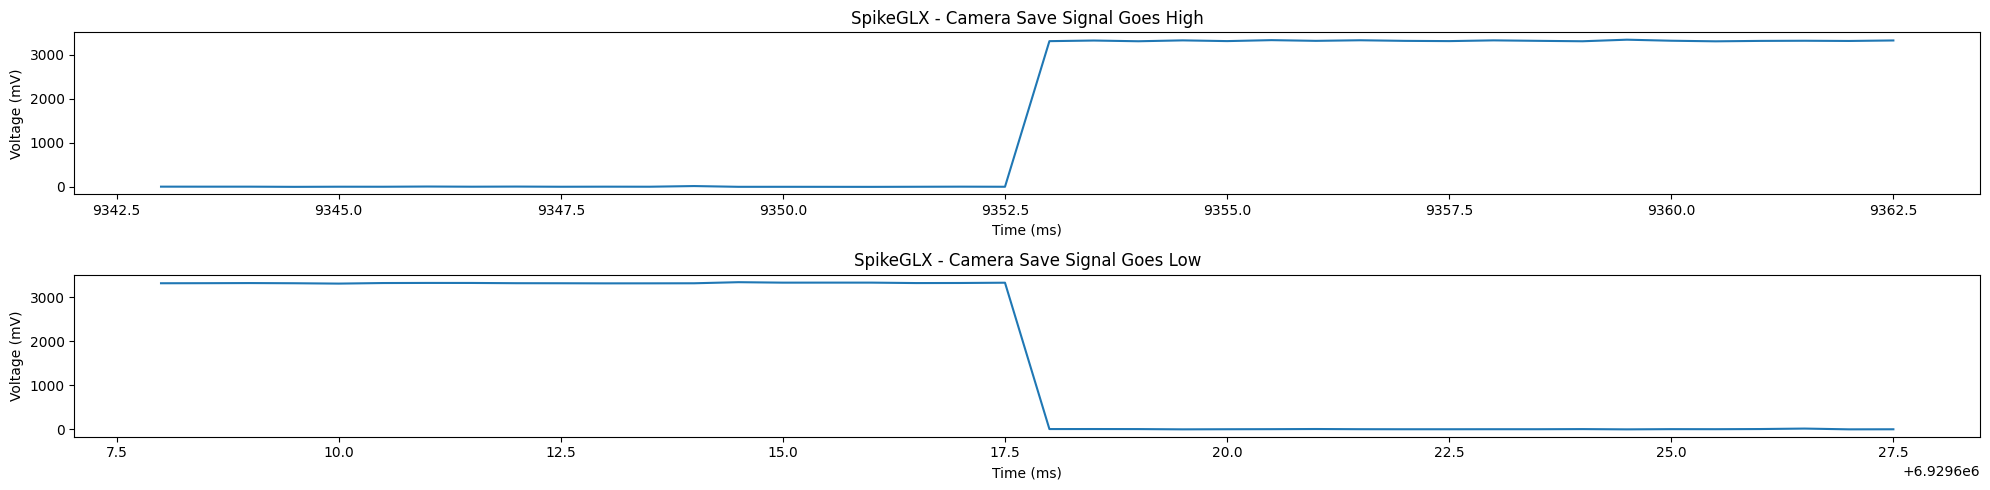

Video Folders:
['231004_Gandalf_104828', '231004_Gandalf_105033', '231004_Gandalf_111328']
Number of cameras: 4
  Camera: e3v831b | Number of videos: 6
  Camera: e3v8360 | Number of videos: 6
  Camera: e3v83ad | Number of videos: 6
  Camera: e3v83d6 | Number of videos: 6
Camera: e3v831b
  Video: e3v831b-20231004T104828-110829.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231004T110829-112830.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231004T112830-114831.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231004T114831-120831.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231004T120831-122831.avi | Frames: 144005 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231004T122831-124348.avi | Frames: 110043 | FPS: 120.0 | Length (minutes): 15.28  
  Total Frames: 830423
Camera: e3v8360
  Video: e3v8360-20231004T104828-110829.avi | Frames: 144123 

  0%|          | 0/413 [00:00<?, ?it/s]

53.0 72


IndexError: index 0 is out of bounds for axis 0 with size 0

In [75]:
from spike_glx.load_SGLX import load_sglx

# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
  4: 'empty'
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
epochs = ['Start trial', 'End trial']
# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

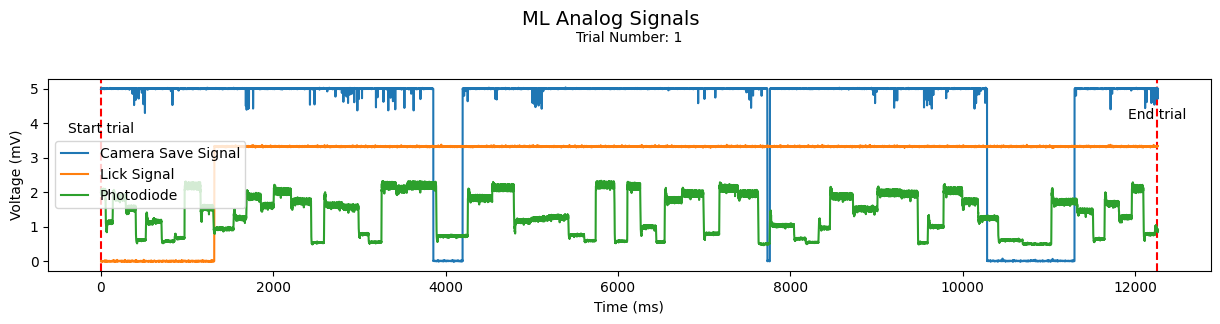

In [78]:
from spike_glx.read_SGLX import plot_analog_ML
plot_analog_ML(session_obj.df, epochs, 1)

In [79]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,lick_raster,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231004,0,gandalf,1,1,1,1,0,0,"[9, 10, 50, 18]","[2.585399997769855, 2766.0004000063054, 11883....","[-4.659415043693736, -4.660104926533945, -4.64...","[0.5065857847569116, 0.4832246716590053, 0.509...","[8628.0, 8612.0, 8608.0, 8608.0, 8619.0, 8619....","[-0.002624990347832201, -0.002624990347832201,...","[3.3093234915896317, 3.3119541138990876, 5.627...","[4.98503285665588, 4.992924754171629, 5.002460...","[2.0055224960231484, 2.01012607764166, 1.96639...",0.0000,12265.0000,2023-10-04 10:48:27.795,2023-10-04 10:48:40.060,2,<NA>,<NA>,12260,2766,11883,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12264,0,"[6, 14, 22, 31, 39, 47, 56, 64, 72, 81, 89, 97..."
1,231004,0,gandalf,2,1,1,1,0,0,"[9, 10, 50, 18]","[281.0438000014983, 343.69470000092406, 10773....","[-0.401602136043741, -0.40115745672803693, -0....","[-8.086664161181009, -8.065052021420318, -8.06...","[5818.0, 5824.0, 5824.0, 5822.0, 5822.0, 5820....","[3.317544186345917, 3.3152423918025193, 3.3149...","[3.3254360534207272, 3.334643231809826, 3.3389...","[4.996870702997573, 4.9863481728959105, 4.9906...","[0.8852083416848938, 0.9381495085234254, 0.892...",12263.8840,23484.8840,2023-10-04 10:48:40.059,2023-10-04 10:48:51.280,281,<NA>,<NA>,11139,343,10773,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11221,1,"[7, 16, 24, 32, 41, 49, 57, 66, 74, 82, 91, 99..."
2,231004,0,gandalf,3,1,1,1,0,0,"[9, 10, 50, 18]","[167.4944999977015, 231.0291000030702, 11993.1...","[5.172200794280728, 5.178153792557004, 5.17815...","[-2.757495679173382, -2.7639424629462965, -2.7...","[6172.0, 6160.0, 6160.0, 6158.0, 6158.0, 6150....","[3.3320126093980584, 3.3287243314000996, 3.320...","[0.00658217199762956, 0.005924517546271019, 0....","[4.992595925104849, 5.002131968169524, 4.98569...","[0.8049745233822716, 0.8322671747404808, 0.776...",23485.0016,35928.0016,2023-10-04 10:48:51.280,2023-10-04 10:49:03.723,167,<NA>,<NA>,12361,231,11993,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12442,2,"[3, 11, 20, 28, 36, 45, 53, 61, 70, 78, 86, 95..."
3,231004,0,gandalf,4,1,1,1,0,0,"[9, 10, 50, 18]","[178.41110000154004, 232.43059999367688, 10845...","[7.722940769370236, 7.722940769370236, 7.75040...","[3.5190583496266097, 3.5190583496266097, 3.543...","[6878.0, 6878.0, 6874.0, 6874.0, 6873.0, 6873....","[3.313269425058244, 3.3283955036013264, 3.3389...","[0.0019785908320277823, 0.000992109151831927, ...","[5.000816651868958, 4.992267096038386, 4.99950...","[1.1456394242840862, 1.0792163446780014, 1.166...",35927.1196,47219.1196,2023-10-04 10:49:03.722,2023-10-04 10:49:15.014,178,<NA>,<NA>,11211,232,10845,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11293,3,"[2, 10, 18, 27, 35, 43, 52, 60, 68, 77, 85, 93..."
4,231004,0,gandalf,5,1,1,1,0,0,"[9, 10, 50, 18]","[183.54190001264215, 248.42910000006668, 11702...","[1.6711105912704878, 1.6711105912704878, 1.654...","[-6.16192551467462, -6.16192551467462, -6.1176...","[6240.0, 6240.0, 6250.0, 6250.0, 6227.0, 6227....","[3.310967630531658, 3.3188594975176424, 3.3168...","[0.003622726964232992, 3.3129405972681782, 3.3...","[4.9958842157868295, 4.985690514775266, 4.9971...","[0.541255163457166, 0.5313903491923005, 0.5415...",47219.6914,59381.6914,2023-10-04 10:49:15.015,2023-10-04 10:49:27.177,183,<NA>,<NA>,12078,248,11702,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12161,4,"[1, 10, 18, 26, 35, 43, 51, 60, 68, 76, 85, 93.

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [8]:
from video.wm_videos import parse_wm_videos

kwargs = {'spikeglx_obj': spikeglx_obj, 
          'session_obj': session_obj, 
          'trial_start': 0,
          'trial_end': len(session_obj.df),
          'epoch_start': 'Trace Start', 
          'epoch_end': 'Outcome Start', 
          'thread_flag': True}

parse_wm_videos(**kwargs)

Parsing Trials for Videos: 0 - 539
  Video complete: Cam: e3v831b | Trial: 1    | Frames: 3836-4014
  Video complete: Cam: e3v831b | Trial: 94   | Frames: 30499-30677
  Video complete: Cam: e3v831b | Trial: 250  | Frames: 3794-3973
  Video complete: Cam: e3v831b | Trial: 464  | Frames: 26-205
  Video complete: Cam: e3v831b | Trial: 42   | Frames: 62434-62611
  Video complete: Cam: e3v831b | Trial: 297  | Frames: 58787-58966
  Video complete: Cam: e3v831b | Trial: 41   | Frames: 61645-61822
  Video complete: Cam: e3v831b | Trial: 178  | Frames: 9347-9524
  Video complete: Cam: e3v831b | Trial: 470  | Frames: 18869-19047
  Video complete: Cam: e3v831b | Trial: 119  | Frames: 50966-51144
  Video complete: Cam: e3v8360 | Trial: 464  | Frames: 26-205
  Video complete: Cam: e3v831b | Trial: 185  | Frames: 14377-14554
  Video complete: Cam: e3v831b | Trial: 23   | Frames: 37919-38097
  Video complete: Cam: e3v831b | Trial: 321  | Frames: 78465-78643
  Video complete: Cam: e3v831b | Trial: 509